# 0.0. IMPORTS

In [1]:
import warnings
import pickle
import joblib
import os as ops

import pandas            as pd
import seaborn           as sns
import random            as r
import sweetviz          as sv
import category_encoders as ce
import xgboost           as xgb

from imblearn              import over_sampling
from IPython.core.display  import HTML
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from pprint                import pprint

from sklearn          import model_selection as ms
from sklearn          import preprocessing   as pp
from sklearn          import metrics         as m
from scikitplot       import metrics         as mt
from keras            import models          as ml
from keras            import layers          as l
from imblearn         import combine         as c
from scipy            import stats           as ss
from sklearn          import neighbors       as nh
from sklearn          import ensemble        as en

warnings.filterwarnings("ignore")

C:\Users\mathe\anaconda3\envs\airbnb\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Aux Functions

In [2]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

# imbalanced metrics ( balanced accuracy and kappa score )
def imbalanced_metrics( model_name, y_val, yhat ):
    # Balanced Accuracy
    balanced_accuracy = m.balanced_accuracy_score( y_val, yhat)
    
    # Kappa Score
    kappa_score = m.cohen_kappa_score( y_val, yhat )
    
    return pd.DataFrame({"balanced_accuracy": "{}".format(np.round(balanced_accuracy,3)),
                         "kappa_score": "{}".format(np.round(kappa_score,3))}, index=[model_name])

# cross validation neural networks
def cross_validation_nn(model_name, model, x, y, epochs=100, verbose=0):
    
    balanced_accuracy_list = []
    kappa_score_list = []

    skf = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        # target variable encoding
        ohe = pp.OneHotEncoder()
        y_train_cv = ohe.fit_transform( y_train_cv.values.reshape( -1, 1 ) ).toarray()
        
        # model training
        model.fit(x_train_cv, y_train_cv, epochs=epochs, verbose=verbose )
        
        # prediction
        pred = model.predict(x_test_cv)
        yhat = ohe.inverse_transform( pred )
        
        # metrics
        balanced_accuracy_list.append( m.balanced_accuracy_score( y_test_cv, yhat) )
        kappa_score_list.append( m.cohen_kappa_score( y_test_cv, yhat ) )
        
    
    balanced_accuracy_mean, balanced_accuracy_std = np.round( np.mean( balanced_accuracy_list ), 2 ), np.round( np.std( balanced_accuracy_list ), 2 )
    kappa_score_mean, kappa_score_std = np.round( np.mean( kappa_score_list ), 2 ), np.round( np.std( kappa_score_list ), 2 )
   
    
    return pd.DataFrame({"Balanced_Accuracy:": "{} +/- {}".format(balanced_accuracy_mean, balanced_accuracy_std),
                         "Kappa_Score": "{} +/- {}".format(kappa_score_mean, kappa_score_std)}, index=[model_name])

# cramer v
def cramer_v( x, y ):

    cm   = pd.crosstab( x, y ).values

    chi2 = ss.chi2_contingency( cm )[0]
    n    = cm.sum()
    r, k = cm.shape
    
    chi2corr = max( 0, chi2 - ( k-1 ) * ( r- 1 ) / ( n-1 ) )
    kcorr    = k - ( k-1 )**2/( n-1 )
    rcorr    = r - ( r-1 )**2/( n-1 )

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )

def plot_cramer_v( columns_list, df ):
    corr_dict = {}
    for i in range( len ( columns_list ) ):
        corr_list = []
        for j in range( len( columns_list ) ):
            ref = columns_list[i]
            feat = columns_list[j]

            # correlation
            corr = cramer_v( df[ ref ], df[ feat ] )

            # append a list
            corr_list.append( corr )

        # appende a correlation list for each ref attributes
        corr_dict[ ref ] = corr_list

    # df
    correlations = pd.DataFrame( corr_dict )
    correlations = correlations.set_index( correlations.columns )

    return sns.heatmap( correlations, annot=True )

# normal cross validation
def cross_validation( model_name, model, x, y ):
    
    balanced_accuracy_list = []
    kappa_score_list = []

    skf = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        # model training
        model.fit(x_train_cv, y_train_cv)
        
        # prediction
        pred = model.predict(x_test_cv)
        
        # metrics
        balanced_accuracy_list.append( m.balanced_accuracy_score( y_test_cv, pred) )
        kappa_score_list.append( m.cohen_kappa_score( y_test_cv, pred ) )
        
    
    balanced_accuracy_mean, balanced_accuracy_std = np.round( np.mean( balanced_accuracy_list ), 2 ), np.round( np.std( balanced_accuracy_list ), 2 )
    kappa_score_mean, kappa_score_std = np.round( np.mean( kappa_score_list ), 2 ), np.round( np.std( kappa_score_list ), 2 )
   
    
    return pd.DataFrame({"Balanced_Accuracy:": "{} +/- {}".format(balanced_accuracy_mean, balanced_accuracy_std),
                         "Kappa_Score": "{} +/- {}".format(kappa_score_mean, kappa_score_std)}, index=[model_name])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Reading Data

In [3]:
df_raw = pd.read_csv( "../datasets/train_users_2.csv" )

# 1.0. DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1. Columns Descriptions

In [5]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

- **id:** user id

- **date_account_created:** the date of account creation

- **timestamp_first_active:** timestamp of the first activity, note that it can be earlier than date_account_created or -date_first_booking because a user can search before signing up

- **date_first_booking: date of first booking**

- **gender**

- **age**

- **signup_method**

- **signup_flow:** the page a user came to signup up from

- **language:** international language preference

- **affiliate_channel:** what kind of paid marketing

- **affiliate_provider:** where the marketing is e.g. google, craigslist, other

- **first_affiliate_tracked:** whats the first marketing the user interacted with before the signing up

- **signup_app**

- **first_device_type**

- **first_browser**

- **country_destination:** this is the target variable to predict

### 1.1.1. Rename Columns

No need, they're already on snakecase.

## 1.2. Data Dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


## 1.3. NA Check

In [7]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### 1.3.1. NA Fulfill

In [8]:
# date first booking - max booking time
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )
df1['date_first_booking'] = df1['date_first_booking'].fillna( df1['date_first_booking'].max() )

# age - median age
df1 = df1[ (df1['age'] > 18) & (df1['age'] < 100) ]
df1['age'] = df1['age'].fillna( df1['age'].mean() )

# first affiliate tracked - drop
df1 = df1.dropna()

## 1.4. Data Types

In [9]:
df1.dtypes

id                                 object
date_account_created               object
timestamp_first_active              int64
date_first_booking         datetime64[ns]
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 1.4.1. Change types

In [10]:
# date account created - datetime
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp first active - datetime
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# age - int
df1['age'] = df1['age'].astype( 'int64' )

## 1.5. Data Proportion

In [11]:
df1['country_destination'].value_counts( normalize=True )

NDF     0.4476
US      0.3919
other   0.0610
FR      0.0300
IT      0.0163
GB      0.0143
ES      0.0138
CA      0.0086
DE      0.0068
NL      0.0048
AU      0.0035
PT      0.0013
Name: country_destination, dtype: float64

We clearly have Imbalanced Data, wich will affect the models.

## 1.6. Descriptive Statistics

In [12]:
df_num = df1[['age','signup_flow']]
df_cat = df1.select_dtypes( exclude=['int64','datetime64[ns]'] )

### 1.6.1. Numerical Attributes

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( lambda x: np.mean( x ) ) ).T
ct2 = pd.DataFrame( df_num.apply( lambda x: np.median( x ) ) ).T

# dispersion metrics - min, max, range, std, skewness, kurtosis
dm1 = pd.DataFrame( df_num.apply( lambda x: np.min( x ) ) ).T
dm2 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) ) ).T
dm3 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) - np.min( x ) ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: np.std( x ) ) ).T
dm5 = pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concat
df_description = pd.concat( [ dm1, dm2, dm3, ct1, ct2, dm4, dm5, dm6 ] ).T
df_description.columns = ( 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' )
df_description

,min,max,range,mean,median,std,skewness,kurtosis
age,19.000,99.000,80.000,36.636,34.000,11.584,1.265,1.792
signup_flow,0.000,25.000,25.000,2.528,0.000,6.613,2.699,5.892


**Problems:**

- Age range ( filtered on NA fulfill )

### 1.6.2. Categorical Attributes

In [14]:
df_cat.drop( columns=['id'] ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,120307,120307,120307,120307,120307,120307,120307,120307,120307,120307
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,55595,64292,116000,77609,77472,63533,106154,56826,41035,53851


# 2.0. DATA FILTERING

In [15]:
df2 = df1.copy()

# 3.0. FEATURE ENGINEERING

In [16]:
df3 = df2.copy()

In [34]:
# days timestamp first active to date account created
df3['date_first_active'] = pd.to_datetime( df3['timestamp_first_active'].dt.strftime('%Y-%m-%d') )
df3['timestamp_first_active_to_date_account_created'] = df3['date_account_created'] - df3['date_first_active']
df3['timestamp_first_active_to_date_account_created'] = df3['timestamp_first_active_to_date_account_created'].apply( lambda x: x.days )

# days timestamp first active to date first booking
df3['timestamp_first_active_to_date_first_booking'] = df3['date_first_booking'] - df3['date_first_active']
df3['timestamp_first_active_to_date_first_booking'] = df3['timestamp_first_active_to_date_first_booking'].apply( lambda x: x.days )

# days date account created to date first booking - CHECK NEGATIVE VALUES
df3['account_created_to_first_booking'] = df3['date_first_booking'] - df3['date_account_created']
df3['account_created_to_first_booking'] = df3['account_created_to_first_booking'].apply( lambda x: x.days )

# # ================ first active ===================

# year
df3['year_date_first_active'] = df3['date_first_active'].dt.year

# month
df3['month_date_first_active'] = df3['date_first_active'].dt.month

# week
df3['week_date_first_active'] = df3['date_first_active'].dt.week

# day
df3['day_date_first_active'] = df3['date_first_active'].dt.day

# day_of_week
df3['day_of_week_date_first_active'] = df3['date_first_active'].dt.dayofweek

# ============ date account created ===============

# year
df3['year_date_account_created'] = df3['date_account_created'].dt.year

# month
df3['month_date_account_created'] = df3['date_account_created'].dt.month

# week
df3['week_date_account_created'] = df3['date_account_created'].dt.week

# day
df3['day_date_account_created'] = df3['date_account_created'].dt.day

# day_of_week
df3['day_of_week_date_account_created'] = df3['date_account_created'].dt.dayofweek

# ============= date first booking ================

# year
df3['year_date_first_booking'] = df3['date_first_booking'].dt.year

# month
df3['month_date_first_booking'] = df3['date_first_booking'].dt.month

# week
df3['week_date_first_booking'] = df3['date_first_booking'].dt.week

# day
df3['day_date_first_booking'] = df3['date_first_booking'].dt.day

# day_of_week
df3['day_of_week_date_first_booking'] = df3['date_first_booking'].dt.dayofweek

# 4.0. RESAMPLING

In [35]:
df4 = df3.drop( columns=['date_account_created','timestamp_first_active','date_first_booking','date_first_active'] )

# numerical 
col_num = df4.select_dtypes( include=['int64','float64'] ).columns.tolist()

# categorical
col_cat = df4.select_dtypes( include=['object'] ).drop( columns=['id','country_destination'] ).columns.tolist()

# one hot encoder
ohe = pp.OneHotEncoder()
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[col_cat] ).toarray(), index=df4.index )

# concat 
df4_encoded = pd.concat( [df4[col_num], df4_dummy], axis=1 )

In [36]:
df_features = df4_encoded.copy()
df_target = df4['country_destination'].copy()

## 4.1. Smote

In [37]:
ratio_balanced =  {'NDF': 53851,
                   'US':  47149,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [38]:
# define
os = over_sampling.SMOTE( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply
features_smote, target_smote = os.fit_resample( df_features, df_target )

In [39]:
df4_balanced = pd.concat( [features_smote, target_smote ], axis=1)
df4_balanced['id'] = df4['id'].copy()

In [40]:
# inverse transform
# separating col numeric from categorical
df_aux_num = features_smote[ col_num ]

# inversing
df_aux_cat = features_smote.drop( col_num, axis=1 )
df_inversed = pd.DataFrame( ohe.inverse_transform( df_aux_cat ), columns=col_cat, index=df_aux_cat.index )

# concat
df_decoded = pd.concat( [df_inversed, df_aux_num], axis=1 )
df_decoded['country_destination'] = target_smote

# 5.0. EXPLORATORY DATA ANALYSIS

In [41]:
df5 = df_decoded.copy()

## 5.1. Univariate Analysis - Balanced Dataset

In [42]:
# # analyzing the dataset
# advert_report = sv.analyze( df5 )

# # report html
# advert_report.show_html( 'report.html' )

**Report on main page as 'report.html'.**

## 5.2. Bivariate Analysis - Imbalanced Dataset

In [43]:
df_bivariate = df4.copy()

### H1. Para todos os destinos, os usuários levam em média 3 dias pra fazer o cadastro no site.
**Falso.** Com exceção de DE, os usuários geralmente se cadastram no site no mesmo dia em que entram pela primeira vez.

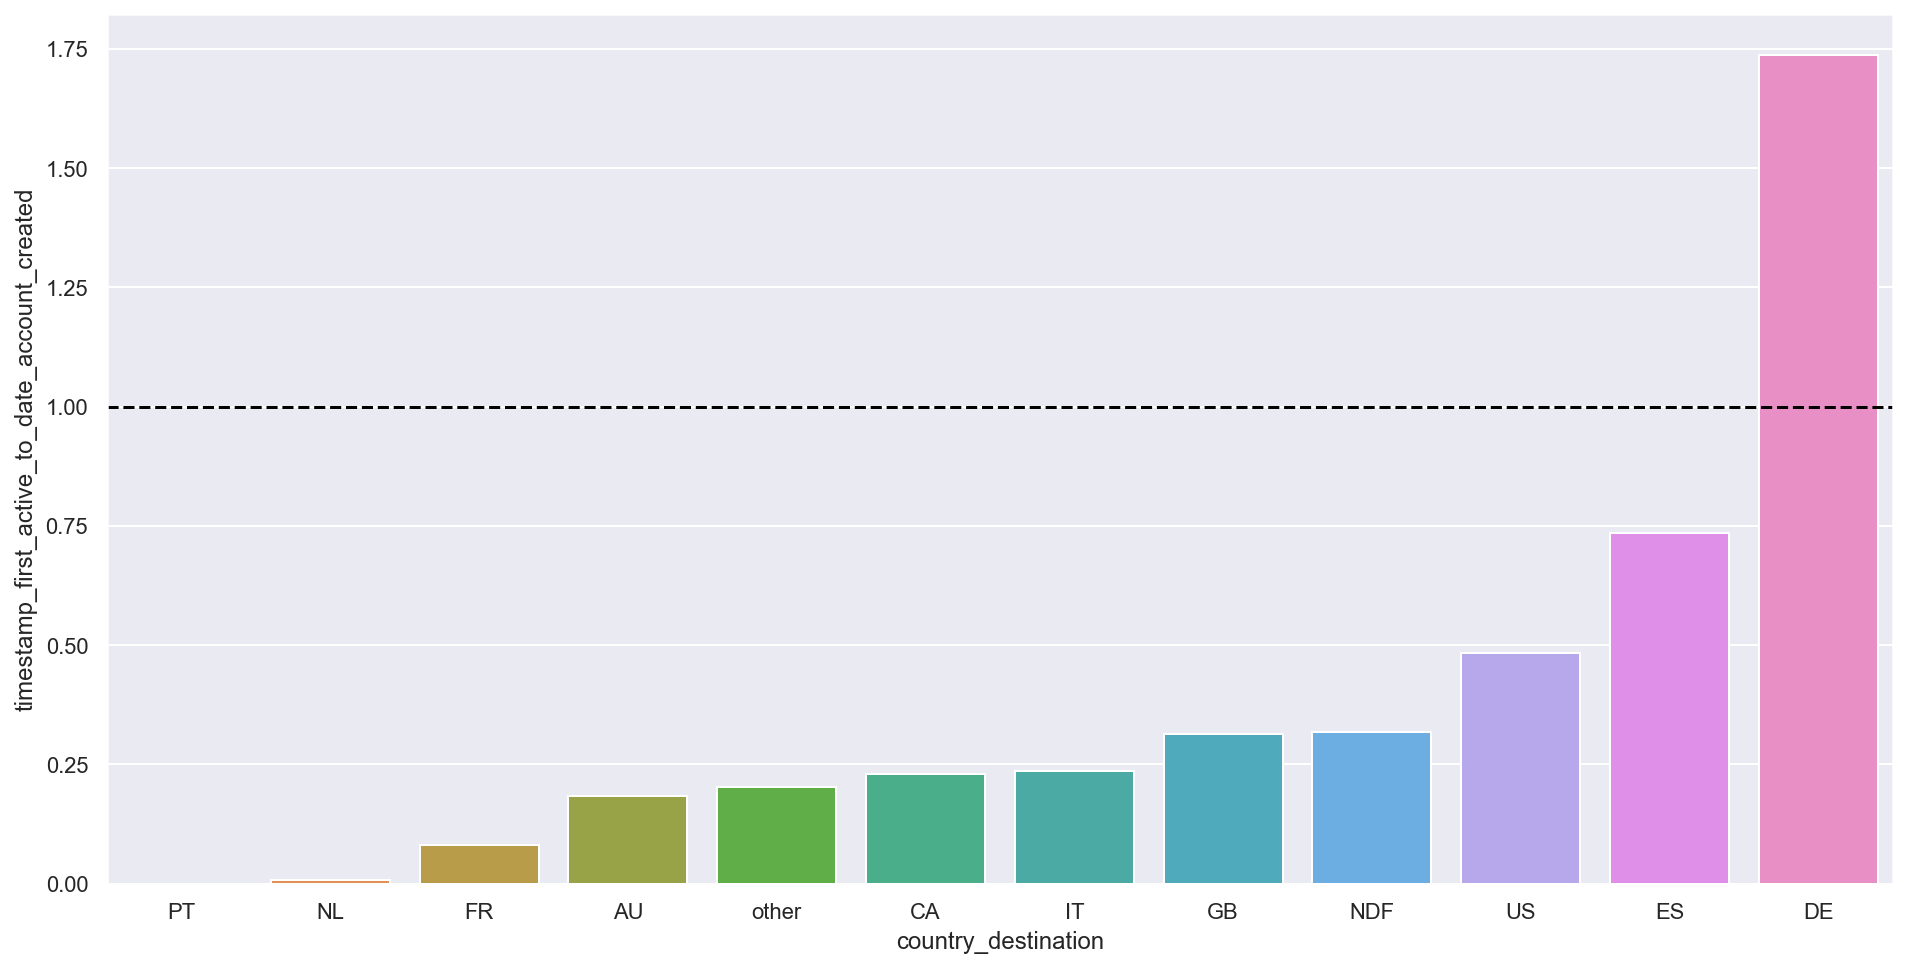

In [44]:
df_h1 = df_bivariate[['timestamp_first_active_to_date_account_created','country_destination']].groupby( 'country_destination' ).mean().sort_values( 'timestamp_first_active_to_date_account_created').reset_index()
sns.barplot( x='country_destination', y='timestamp_first_active_to_date_account_created', data=df_h1 );
plt.axhline( 1, 0, 1, color='black', linestyle='--' );

### H2. Para todos os destinos, os usuários levam em média 30 dias pra fazer o primeiro booking.
**Falso**. Em mediana, devido a outliers, os usuários levam menos de 6 dias pra fazer o primeiro booking.

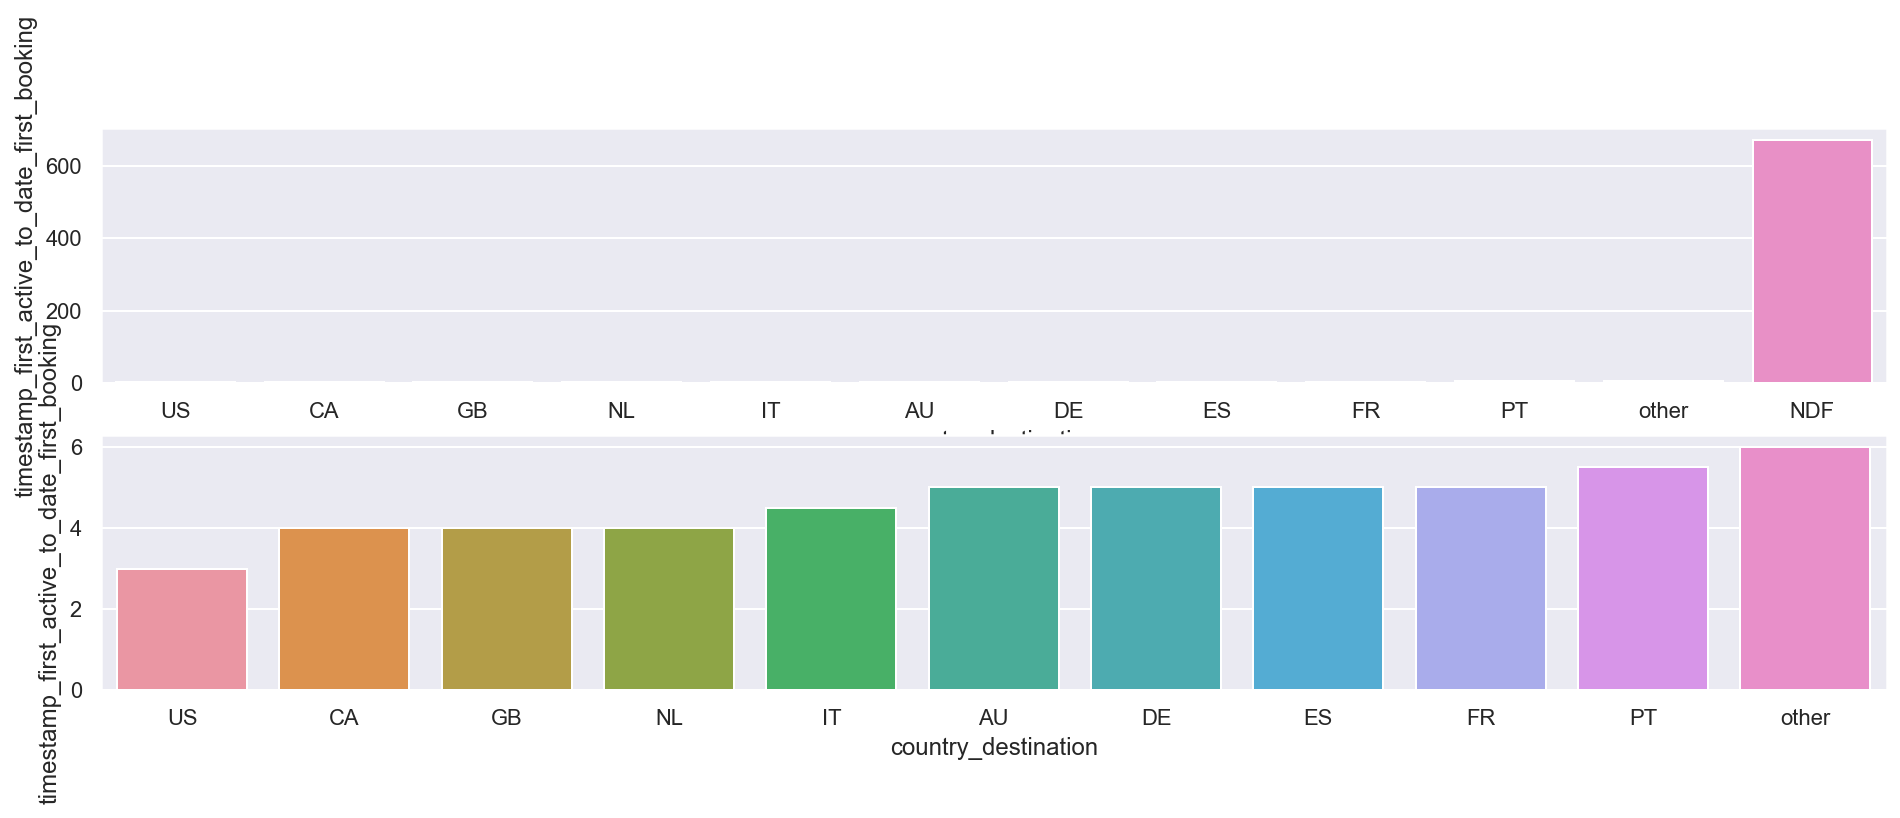

In [45]:
plt.subplot( 3, 1, 1 )
df_h2 = df_bivariate[['timestamp_first_active_to_date_first_booking','country_destination']].groupby( 'country_destination' ).median().sort_values( 'timestamp_first_active_to_date_first_booking').reset_index()
sns.barplot( x='country_destination', y='timestamp_first_active_to_date_first_booking', data=df_h2 );

plt.subplot( 3, 1, 2 )
df_aux = df_h2[ df_h2['country_destination'] != 'NDF' ]
sns.barplot( x='country_destination', y='timestamp_first_active_to_date_first_booking', data=df_aux );

### H3. O volume de reservas para os verões nos Estados Unidos aumenta em média 30% ao ano.
**Verdadeira.** Em média, o volume de reservas para os verões nos estados unidos aumenta 87% ao ano.

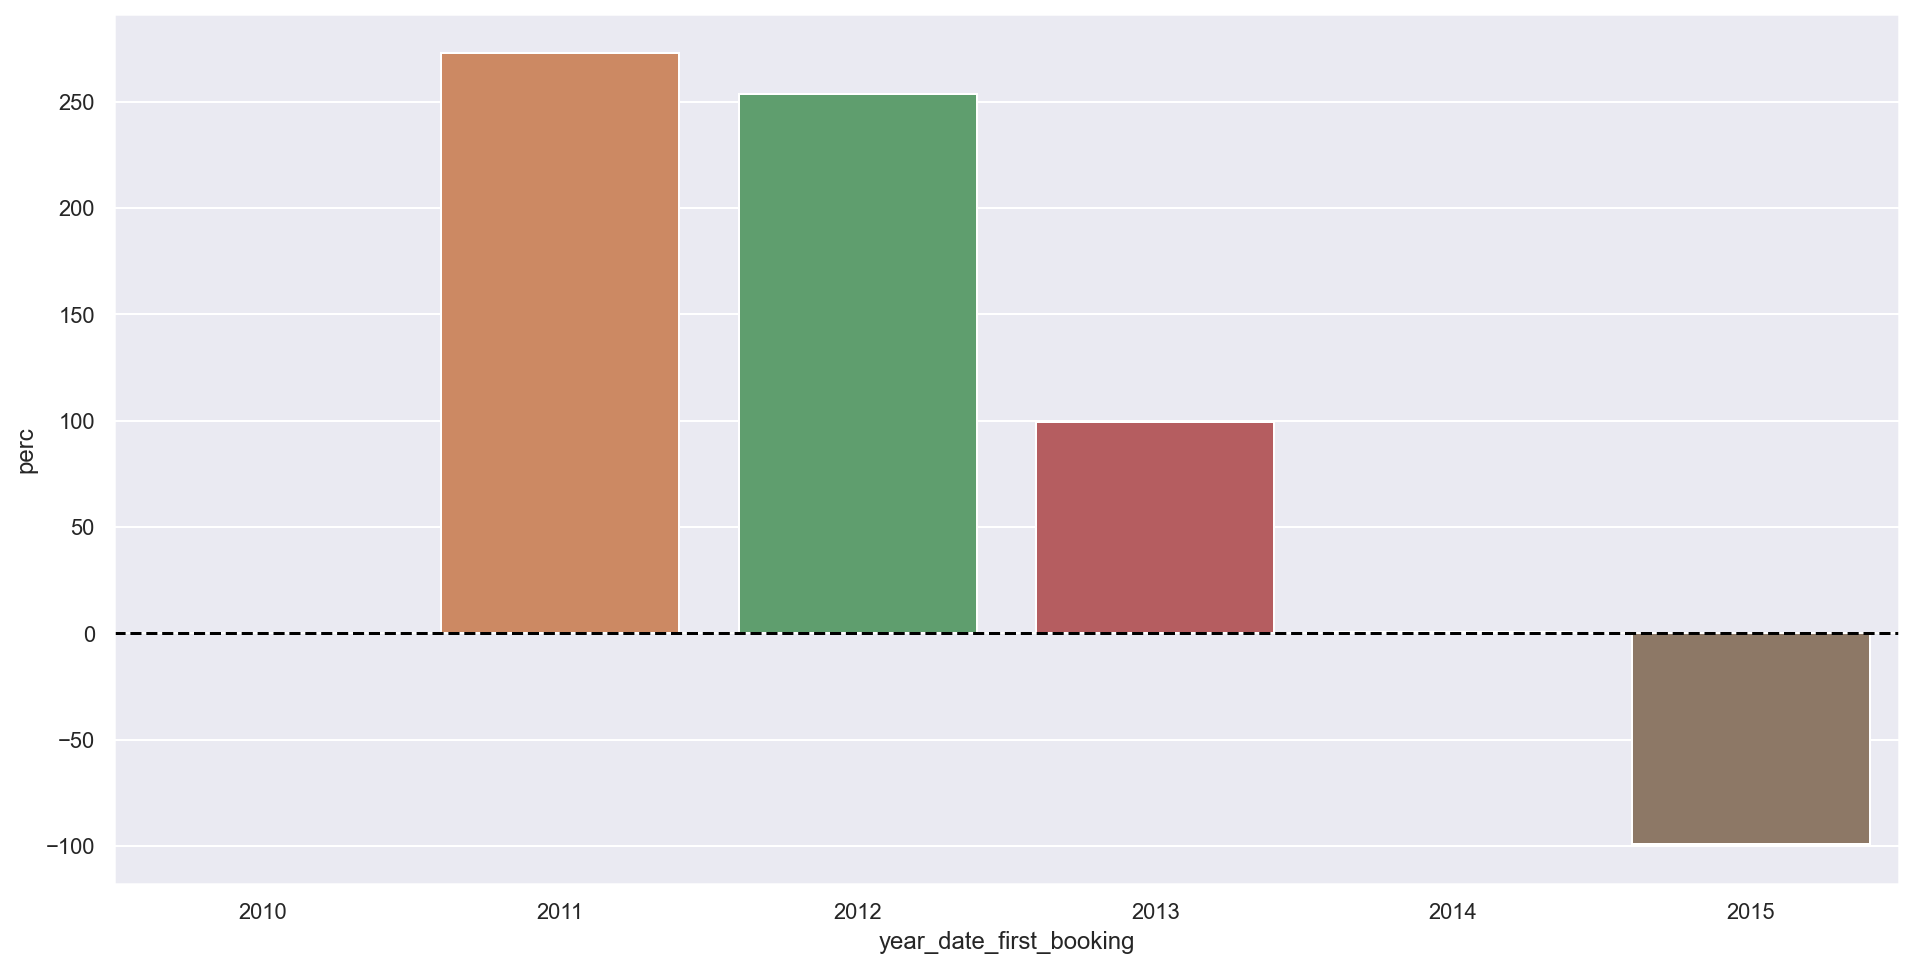

In [46]:
summer_months = [ 6, 7, 8 ]

df_h3 = df_bivariate[['year_date_first_booking','month_date_first_booking','country_destination']].groupby(['year_date_first_booking','month_date_first_booking','country_destination']).size().reset_index()
df_h3 = df_h3[ ( df_h3['month_date_first_booking'].isin( summer_months ) ) & ( df_h3['country_destination'] == 'US' ) ]
df_h3 = df_h3.rename( columns={ 0 : 'count'} )

us_summer_booking = df_h3[['year_date_first_booking','count']].groupby('year_date_first_booking').sum().reset_index()
us_summer_booking['perc'] = 100 * us_summer_booking['count'].pct_change().fillna( 0 )

sns.barplot( x='year_date_first_booking', y='perc', data=us_summer_booking );
plt.axhline( 0, 0, 1, color='black', linestyle='--');

### H4. Usuários do sexo feminino fazem 10% mais reservas para países fora dos Estados Unidos.

**Verdadeira.** Usuários do sexo femininos fazem 167.19% mais reservas para países fora dos Estados Unidos.

In [47]:
df_h4 = df_bivariate[['id','country_destination','gender']].groupby( ['country_destination','gender'] ).count().reset_index()
df_h4 = df_h4[df_h4['gender'] == 'FEMALE']

df_others = df_h4[df_h4['country_destination'] != 'US']
df_us = df_h4[df_h4['country_destination'] == 'US']

perc_womans = 100 * ( df_others['id'].sum() / df_us['id'].sum() )
print( 'Usuários do sexo femininos fazem {:.2f}% mais reservas para países fora dos Estados Unidos'.format( perc_womans ) )

Usuários do sexo femininos fazem 167.19% mais reservas para países fora dos Estados Unidos


### H5. O Google representa 40% do canal de marketing das reservas feitas pros Estados Unidos.

### H6. O destino Estados Unidos representa mais de 20% em todos os canais de marketing.

### H7. A idade média das pessoas é 35 anos em todos os detinos.

### H8. A porcentagem das pessoas que usam a língua inglês para reservar acomodações em qualquer destino é maior que 90%.

### H9. O número de reservas do Airbnb cresce 10% ao ano.

### H10. As pessoas fazem 20% mais reservas pelo celular ( Android ou IOS)

## 5.3. Multivariate Analysis - Balanced Dataset

In [48]:
num_attributes = df_bivariate.select_dtypes( include=['int64','float64'] )
cat_attributes = df_bivariate.select_dtypes( exclude=['int64','float64'] )

### 5.3.1. Pearson Correlation - Numerical Attributes

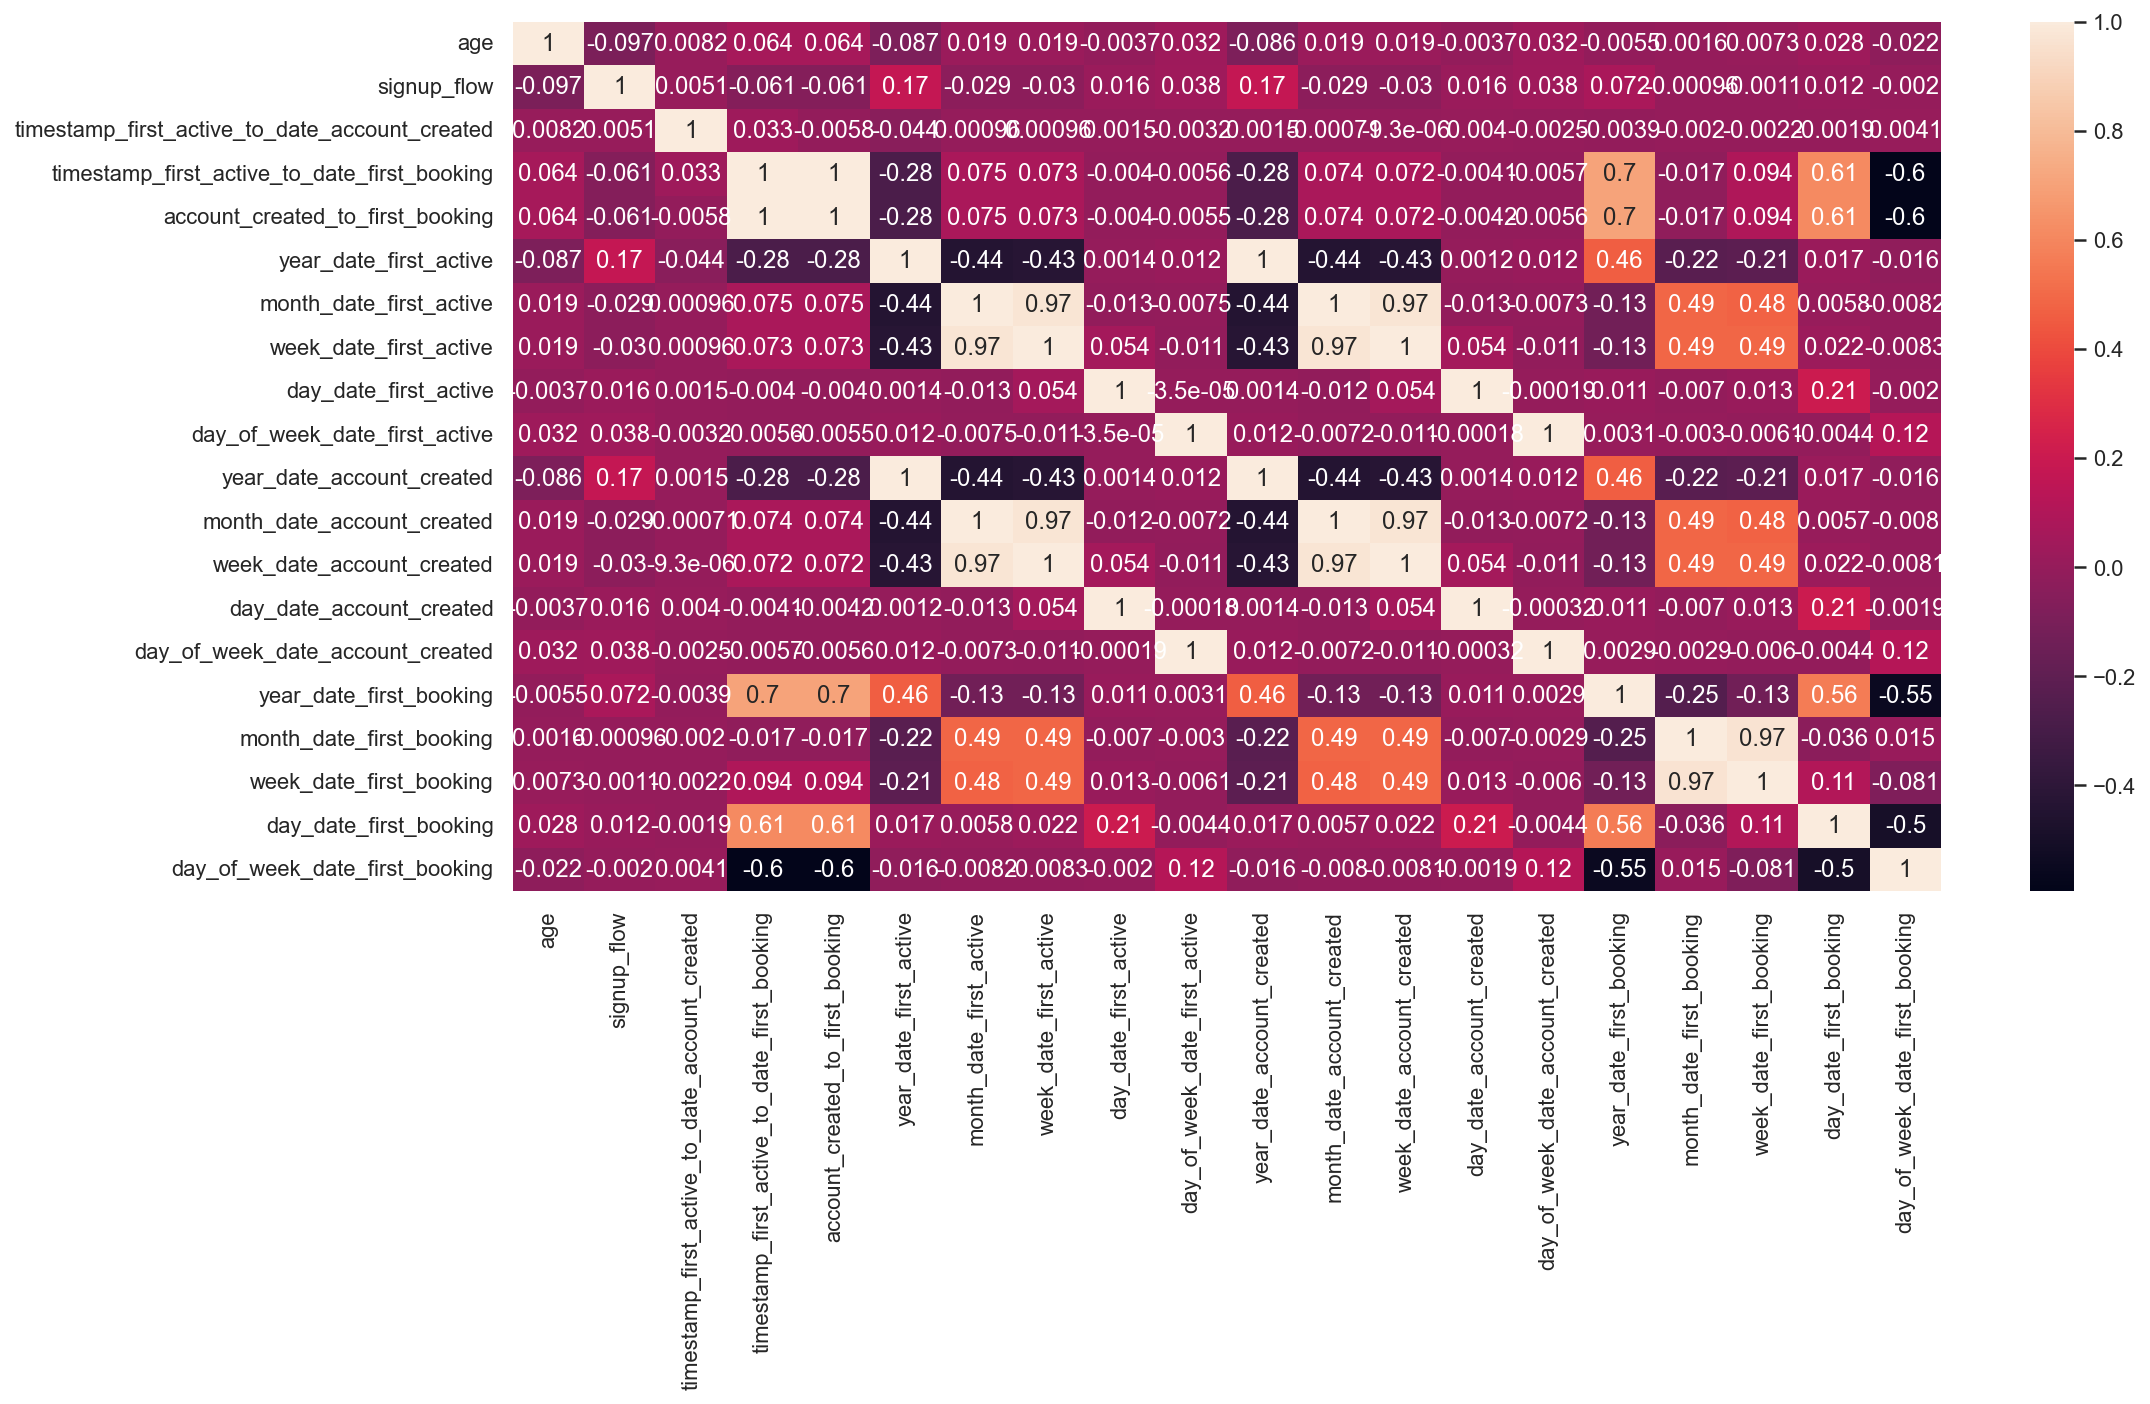

In [49]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot=True );

### 5.3.2. Cramer's V - Categorical Attributes

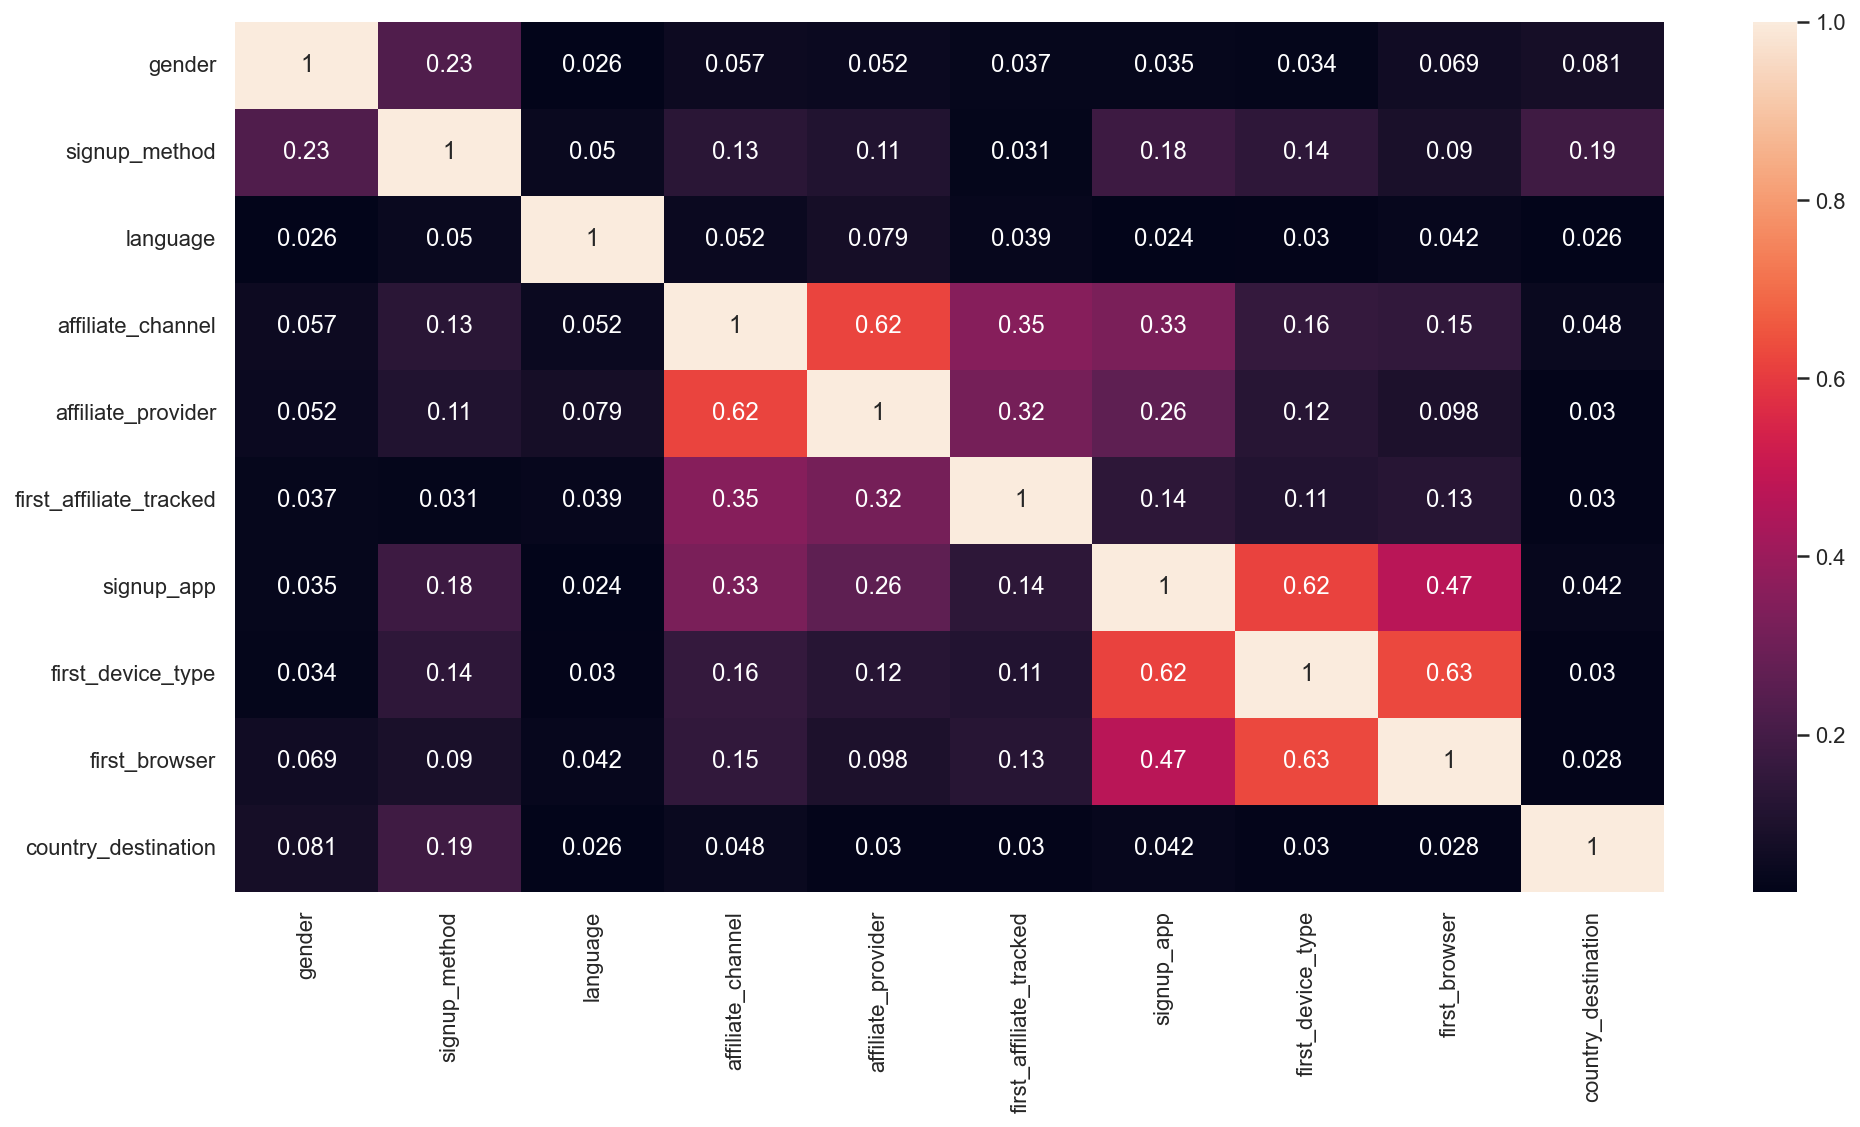

In [50]:
cat_attributes_list = cat_attributes.drop( columns=['id'] ).columns.tolist()
plot_cramer_v( cat_attributes_list, cat_attributes );

### 5.3.3. Conclusion

Features with high correlation to each other - one of them have to be deleted because they explain the same phenomenom.

This avoids the chances of the model to overfitting.

**Numerical:**

- **timestamp_first_active_to_date_first_booking** -> account_created_to_first_booking
- month_date_first_active -> **week_date_first_active**
- month_date_first_booking -> **week_date_first_booking**
- **year_date_first_active** -> year_date_account_created
- **month_date_first_active** -> month_date_account_created
- **day_of_week_date_first_active** -> day_of_week_date_account_created
- **week_date_first_active** -> week_date_account_created
- **day_date_first_active** -> day_date_account_created
- **week_date_first_active** -> month_date_account_created
- **month_date_first_active** -> week_date_account_created

**Categorical:**
    
None

# 6.0. DATA PREPARATION

In [34]:
df6 = df5.drop( columns=['timestamp_first_active_to_date_first_booking','week_date_first_active','week_date_first_booking','year_date_first_active',
                         'month_date_first_active','day_of_week_date_first_active','week_date_first_active','day_date_first_active','week_date_first_active',
                         'month_date_first_active'] )

## 6.1. Rescaling

In [35]:
ssr = pp.StandardScaler()
mms = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [36]:
# age
df6['age'] = ssr.fit_transform( df6[['age']].values )
pickle.dump( ssr, open( '../preparation_parameters/age_scaler.pkl', 'wb' ) )

# signup_flow
df6['signup_flow'] = mms.fit_transform( df6[['signup_flow']].values )
pickle.dump( mms, open( '../preparation_parameters/signup_flow_scaler.pkl', 'wb' ) )

# timestamp_first_active_to_date_account_created 
df6['timestamp_first_active_to_date_account_created'] = mms.fit_transform( df6[['timestamp_first_active_to_date_account_created']].values )
pickle.dump( mms, open( '../preparation_parameters/timestamp_first_active_to_date_account_created_scaler.pkl', 'wb' ) )

# account_created_to_first_booking - check negative values
df6['account_created_to_first_booking'] = mms.fit_transform( df6[['account_created_to_first_booking']].values )
pickle.dump( mms, open( '../preparation_parameters/account_created_to_first_booking_scaler.pkl', 'wb' ) )

# year_date_account_created  
df6['year_date_account_created'] = mms.fit_transform( df6[['year_date_account_created']].values )
pickle.dump( mms, open( '../preparation_parameters/year_date_account_created_scaler.pkl', 'wb' ) )

# year_date_first_booking
df6['year_date_first_booking'] = mms.fit_transform( df6[['year_date_first_booking']].values ) 
pickle.dump( mms, open( '../preparation_parameters/year_date_first_booking_scaler.pkl', 'wb' ) )

## 6.2. Encoding

In [37]:
te = ce.TargetEncoder()

In [38]:
# gender  
df6 = pd.get_dummies( df6, columns=['gender'] )

# signup_method   
df6 = pd.get_dummies( df6, columns=['signup_method'] )

# language                
df6 = df6.drop( columns=['language'] )

# affiliate_channel
countries = { 'NDF': 0, 'US': 1, 'other': 2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9,'AU':10, 'PT':11 }
df6['affiliate_channel'] = te.fit_transform( df6[['affiliate_channel']].values, df6['country_destination'].map( countries ) )
pickle.dump( te, open( '../preparation_parameters/affiliate_channel_encoder.pkl', 'wb' ) )

# affiliate_provider     
df6 = df6.drop( columns=['affiliate_provider'] )

# first_affiliate_tracked
df6['first_affiliate_tracked'] = te.fit_transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( countries ) )
pickle.dump( te, open( '../preparation_parameters/first_affiliate_tracked_encoder.pkl', 'wb' ) )

# signup_app  
df6 = df6.drop( columns=['signup_app'] )

# first_device_type 
df6 = df6.drop( columns=['first_device_type'] )

# first_browser
df6 = df6.drop( columns=['first_browser'] )

## 6.3. Transformation

In [39]:
# month_date_account_created
df6['month_date_account_created_sin'] = df6['month_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
df6['month_date_account_created_cos'] = df6['month_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

# week_date_account_created
df6['week_date_account_created_sin'] = df6['week_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df6['week_date_account_created_cos'] = df6['week_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_date_account_created
df6['day_date_account_created_sin'] = df6['day_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
df6['day_date_account_created_cos'] = df6['day_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

# day_of_week_date_account_created
df6['day_of_week_date_account_created_sin'] = df6['day_of_week_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_date_account_created_cos'] = df6['day_of_week_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# month_date_first_booking
df6['month_date_first_booking_sin'] = df6['month_date_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
df6['month_date_first_booking_cos'] = df6['month_date_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

# day_date_first_booking
df6['day_date_first_booking_sin'] = df6['day_date_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
df6['day_date_first_booking_cos'] = df6['day_date_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

# day_of_week_date_first_booking
df6['day_of_week_date_first_booking_sin'] = df6['day_of_week_date_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_date_first_booking_cos'] = df6['day_of_week_date_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# 7.0. FEATURE SELECTION

In [40]:
df7 = df6.drop( columns=['month_date_account_created','week_date_account_created','day_date_account_created','day_of_week_date_account_created','month_date_first_booking',
                         'day_date_first_booking','day_of_week_date_first_booking'] )

## 7.1. Splitting Train/Validation Datasets

In [41]:
# X = df7.drop( columns=['country_destination'] )
# Y = df7['country_destination'].copy()

# x_train, x_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.2. Boruta

In [42]:
# # training and test dataset for boruta
# x_train_n = x_train.values
# y_train_n = y_train.map( countries ).values

# # define random forest regressor
# rf = RandomForestRegressor( n_jobs = -1 )

# # define boruta
# boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state=42 ).fit( x_train_n , y_train_n )

## 7.3. Boruta Results

In [43]:
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = x_train.copy()
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

# # cols not selected
# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns , cols_selected_boruta ) )

## 7.4. Final Features Selected

In [44]:
cols_delete = [ 'signup_method_basic','signup_method_facebook', 'signup_method_google', 'timestamp_first_active_to_date_account_created', 'country_destination' ]

# 8.0. MACHINE LEARNING

In [45]:
X = df7.drop( cols_delete, axis=1 )
Y = df7['country_destination'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 8.1. Random Model

In [46]:
# country_destination_list = df6['country_destination'].drop_duplicates().sort_values().to_list()
# k = y_val.shape[0]
# weights = df1['country_destination'].value_counts( normalize=True ).sort_index().to_list()

# yhat_random = r.choices( population=country_destination_list,
#                          weights=weights,
#                          k=k )

### 8.1.1. Imbalanced Metrics and Confusion Matrix

In [47]:
# imbalanced_metrics( 'Random Model', y_val, yhat_random )

In [48]:
# # Confusion Matrix
# mt.plot_confusion_matrix( y_val, yhat_random, normalize=False );

## 8.2. Neural Network - MLP

In [49]:
# # y train preparation
# ohe = pp.OneHotEncoder()
# y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [50]:
# # model definition
# model_nn = ml.Sequential()
# model_nn.add( l.Dense( 64, input_dim=x_train.shape[1], activation='relu' ) )
# model_nn.add( l.Dense( 12, activation='softmax' ) )

# # model compile
# model_nn.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# # model training
# model_nn.fit( x_train, y_train_nn, epochs=100, verbose=0 )

In [51]:
# # prediction
# pred_nn = model_nn.predict( x_val )
# yhat_nn = ohe.inverse_transform( pred_nn )

# # # prediction prepare
# # y_val_nn = y_val.to_numpy()
# # yhat_nn = yhat_nn.reshape( 1, -1 )[0]

### 8.2.1. Imbalanced Metrics and Confusion Matrix

In [52]:
# imbalanced_metrics( 'Neural Network', y_val, yhat_nn )

In [53]:
# # Confusion Matrix
# mt.plot_confusion_matrix( y_val, yhat_nn, normalize=False );

### 8.2.2. Cross Validation

In [54]:
# # cv
# cross_validation( "neural", model_nn, X, Y )

## 8.3. KNN

In [55]:
# # model definition
# knn = nh.KNeighborsClassifier( n_neighbors=10 )

# # model training
# knn.fit( x_train, y_train )

# # model prediction
# yhat_knn = knn.predict( x_val )

### 8.3.1. Imbalanced Metrics and Confusion Matrix

In [56]:
# imbalanced_knn = imbalanced_metrics( 'KNN', y_val, yhat_knn )
# imbalanced_knn

In [57]:
# # Confusion Matrix
# mt.plot_confusion_matrix( y_val, yhat_knn, normalize=False );

### 8.3.2. Cross Validation

In [58]:
# # cv
# cv_knn = cross_validation( "KNN", knn, X, Y )
# cv_knn

## 8.4. Extra Trees 

In [59]:
# # model definition
# et = en.ExtraTreesClassifier( n_estimators=150, n_jobs=-1, random_state=42 )

# # model training
# et.fit( x_train, y_train )

# # model prediction
# yhat_et = et.predict( x_val )

### 8.4.1. Imbalanced Metrics and Confusion Matrix

In [60]:
# imbalanced_et = imbalanced_metrics( "Extra Trees", y_val, yhat_et )
# imbalanced_et

In [61]:
# # Confusion Matrix
# mt.plot_confusion_matrix( y_val, yhat_et, normalize=False )

### 8.4.2. Cross Validation

In [62]:
# # cv
# cv_et = cross_validation( "Extra Trees", et, X, Y )
# cv_et

## 8.5. Random Forest

In [151]:
# model definition
rf = en.RandomForestClassifier( n_estimators=10, criterion='entropy', random_state=42, max_depth=20 )

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict( x_val )

### 8.5.1. Imbalanced Metrics and Confusion Matrix

In [152]:
imbalanced_rf = imbalanced_metrics( "Random Forest", y_val, yhat_rf )
imbalanced_rf

,balanced_accuracy,kappa_score
Random Forest,0.895,0.885


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

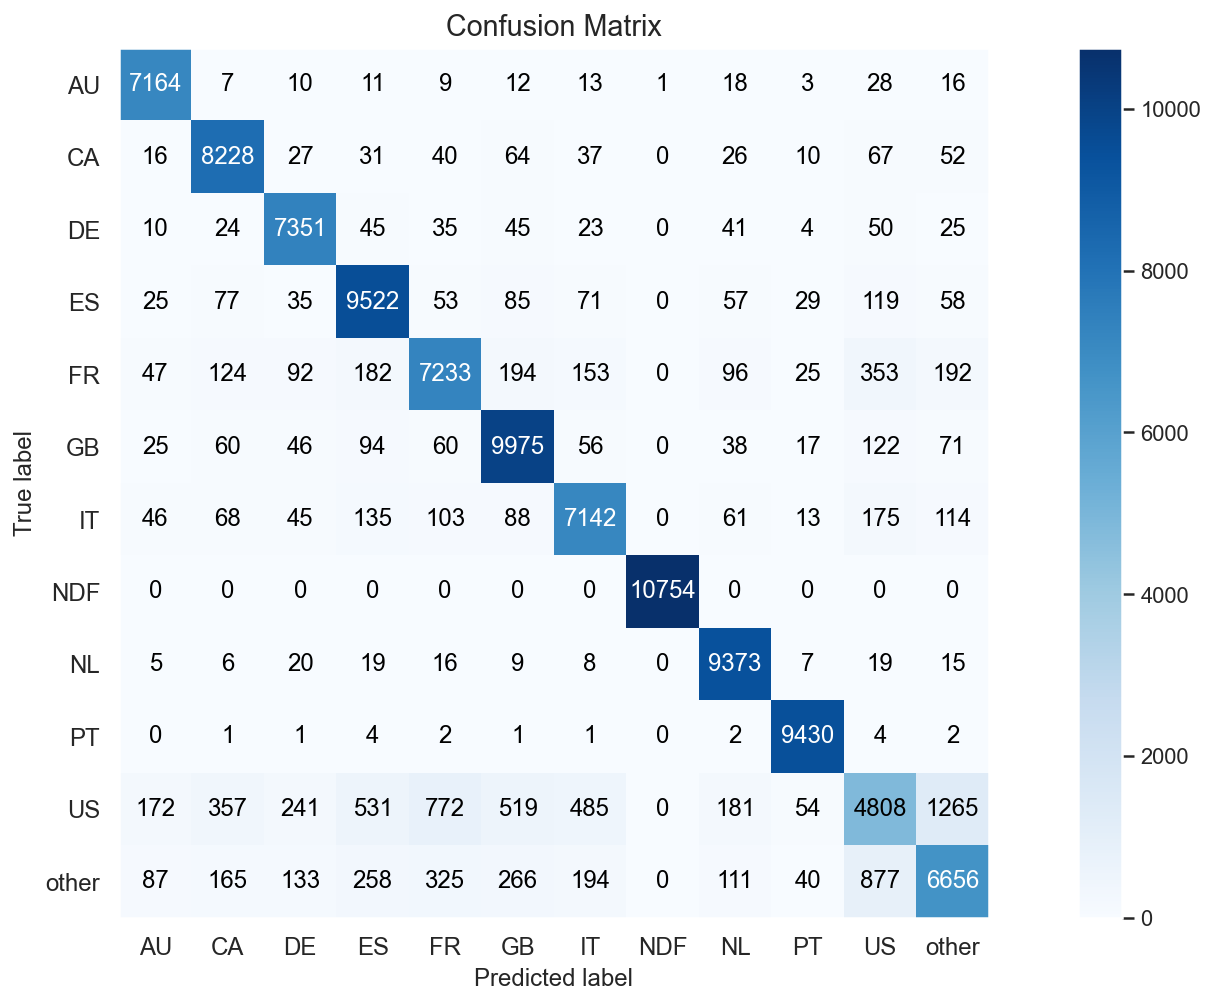

In [153]:
# Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_rf, normalize=False )

### 8.5.2. Cross Validation

In [66]:
# # cv
# cv_rf = cross_validation( "Random Forest", rf, X, Y )
# cv_rf

## 8.6. XGBoost

In [67]:
# # label encoding country destination train
# y_train_xgb = y_train.map( countries )

# # label encoding country destination validation
# y_val_xgb = y_val.map( countries )

In [68]:
# # model definition
# model_xgb = xgb.XGBClassifier( objective='multi:softmax' )

# # model_training
# model_xgb.fit( x_train, y_train_xgb )

# # model prediction
# yhat_xgb = model_xgb.predict( x_val )

### 8.6.1. Imbalanced Metrics and Confusion Matrix

In [69]:
# imbalanced_xgb = imbalanced_metrics( "XGBoost", y_val_xgb, yhat_xgb )
# imbalanced_xgb

In [70]:
# # Confusion Matrix
# mt.plot_confusion_matrix( y_val_xgb, yhat_xgb, normalize=False )

### 8.6.2. Cross Validation

In [71]:
# # label encoding country destination
# Y_xgb = df7['country_destination'].map( countries )

In [72]:
# # cv
# cv_xgb = cross_validation( "XGBoost", model_xgb, X, Y_xgb )
# cv_xgb

# 9.0. Models Performance

## 9.1. Imbalanced Metrics Performance

In [73]:
# imbalanced_performance = pd.concat( [ imbalanced_knn, imbalanced_et, imbalanced_rf, imbalanced_xgb ], axis=0 )
# imbalanced_performance

## 9.2. CV Performance

In [74]:
# models_performance = pd.concat( [ cv_knn, cv_et, cv_rf, cv_xgb ], axis=0 )
# models_performance

# 10.0. HYPERPARAMETER FINE TUNING FOR EXTRA TREES

In [75]:
# print('Parameters currently in use:\n')
# pprint(et.get_params())

## 10.1. Random Hyperparameter Grid

In [76]:
# # Number of trees in extra trees
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200 , num = 11)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 4, 8 ]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

In [77]:
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

## 10.2. Random Search

In [78]:
# # model definition
# et_tuning = en.ExtraTreesClassifier()

# # random search
# et_random = ms.RandomizedSearchCV( estimator=et_tuning, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1 )

# # model training
# et_random.fit( X, Y )

## 10.3. Best Model Training

**For not being able to run Fine Tuning method due to memory imcapacibility, I decided to continue with Random Forest and make the Tuning by hand**

Training the model with all available data ( train/validation ) and saving it.

In [154]:
# model definition
model_rf = en.RandomForestClassifier( n_estimators=10, criterion='entropy', random_state=42, max_depth=20 )

# model training
model_rf.fit( X, Y )

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=10,
                       random_state=42)

In [164]:
# # single tree size
# joblib.dump( model_rf.estimators_[0], "../model/first_tree_from_model_rf.joblib" ) 
# print( f"Single tree size: {np.round(ops.path.getsize('../model/first_tree_from_model_rf.joblib') / 1024 / 1024, 2) } MB")

# full rf model compressed
joblib.dump( model_rf, "../model/full_rf_model_compressed.joblib", compress=3 ) 
print( f"Random Forest full size: {np.round(ops.path.getsize('../model/full_rf_model_compressed.joblib') / 1024 / 1024, 2) } MB")

print('\n')

# parameters currently in use
print('Parameters currently in use:\n')
pprint( model_rf.get_params() )

Random Forest full size: 16.79 MB


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


**Note that the original Random Forest model had almost 2GB in memory, but with a 5% accuracy cost I reduced it for 16.79 MB. This accuracy loss certainly pays of the Cloud cost cutting.**

# 11.0. DEPLOY

## 11.1. Airbnb Class

In [98]:
import pickle
import pandas as pd

class Airbnb( object ):
    def __init__( self ):
        self.homepath                                              = 'Users/mathe/Repos_ComunidadeDS/airbnb_new_user_bookings'
        self.account_created_to_first_booking_scaler               = pickle.load( open( self.homepath + 'preparation_parameters/account_created_to_first_booking_scaler.pkl', 'rb' ) )
        self.affiliate_channel_encoder                             = pickle.load( open( self.homepath + 'preparation_parameters/affiliate_channel_encoder.pkl', 'rb' ) )
        self.age_scaler                                            = pickle.load( open( self.homepath + 'preparation_parameters/age_scaler.pkl', 'rb' ) )
        self.first_affiliate_tracked_encoder                       = pickle.load( open( self.homepath + 'preparation_parameters/first_affiliate_tracked_encoder.pkl', 'rb' ) )
        self.signup_flow_scaler                                    = pickle.load( open( self.homepath + 'preparation_parameters/signup_flow_scaler.pkl', 'rb' ) )
        self.timestamp_first_active_to_date_account_created_scaler = pickle.load( open( self.homepath + 'preparation_parameters/timestamp_first_active_to_date_account_created_scaler.pkl', 'rb' ) )
        self.year_date_account_created_scaler                      = pickle.load( open( self.homepath + 'preparation_parameters/year_date_account_created_scaler.pkl', 'rb' ) )
        self.year_date_first_booking_scaler                        = pickle.load( open( self.homepath + 'preparation_parameters/year_date_first_booking_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.0. DATA DESCRIPTION
        ### 1.3.1. NA Fulfill

        # date first booking - max booking time
        df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )
        df1['date_first_booking'] = df1['date_first_booking'].fillna( df1['date_first_booking'].max() )

        # age - median age
        df1 = df1[ (df1['age'] > 18) & (df1['age'] < 100) ]
        df1['age'] = df1['age'].fillna( df1['age'].mean() )

        # first affiliate tracked - drop
        df1 = df1.dropna()

        ### 1.4.1. Change types

        # date account created - datetime
        df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

        # timestamp first active - datetime
        df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

        # age - int
        df1['age'] = df1['age'].astype( 'int64' )
        
        return df1
    
    def feature_engineering( self, df3 ):
        # 3.0. FEATURE ENGINEERING

        df3 = df2.copy()

        # days timestamp first active to date account created
        df3['date_first_active'] = pd.to_datetime( df3['timestamp_first_active'].dt.strftime('%Y-%m-%d') )
        df3['timestamp_first_active_to_date_account_created'] = df3['date_account_created'] - df3['date_first_active']
        df3['timestamp_first_active_to_date_account_created'] = df3['timestamp_first_active_to_date_account_created'].apply( lambda x: x.days )

        # days timestamp first active to date first booking
        df3['timestamp_first_active_to_date_first_booking'] = df3['date_first_booking'] - df3['date_first_active']
        df3['timestamp_first_active_to_date_first_booking'] = df3['timestamp_first_active_to_date_first_booking'].apply( lambda x: x.days )

        # days date account created to date first booking - CHECK NEGATIVE VALUES
        df3['account_created_to_first_booking'] = df3['date_first_booking'] - df3['date_account_created']
        df3['account_created_to_first_booking'] = df3['account_created_to_first_booking'].apply( lambda x: x.days )

        # # ================ first active ===================

        # year
        df3['year_date_first_active'] = df3['date_first_active'].dt.year

        # month
        df3['month_date_first_active'] = df3['date_first_active'].dt.month

        # week
        df3['week_date_first_active'] = df3['date_first_active'].dt.week

        # day
        df3['day_date_first_active'] = df3['date_first_active'].dt.day

        # day_of_week
        df3['day_of_week_date_first_active'] = df3['date_first_active'].dt.dayofweek

        # ============ date account created ===============

        # year
        df3['year_date_account_created'] = df3['date_account_created'].dt.year

        # month
        df3['month_date_account_created'] = df3['date_account_created'].dt.month

        # week
        df3['week_date_account_created'] = df3['date_account_created'].dt.week

        # day
        df3['day_date_account_created'] = df3['date_account_created'].dt.day

        # day_of_week
        df3['day_of_week_date_account_created'] = df3['date_account_created'].dt.dayofweek

        # ============= date first booking ================

        # year
        df3['year_date_first_booking'] = df3['date_first_booking'].dt.year

        # month
        df3['month_date_first_booking'] = df3['date_first_booking'].dt.month

        # week
        df3['week_date_first_booking'] = df3['date_first_booking'].dt.week

        # day
        df3['day_date_first_booking'] = df3['date_first_booking'].dt.day

        # day_of_week
        df3['day_of_week_date_first_booking'] = df3['date_first_booking'].dt.dayofweek
        
        return df3
    
    def data_preparation( self, df6 ):
        # 6.0. DATA PREPARATION

        df6 = df3.drop( columns=['timestamp_first_active_to_date_first_booking','week_date_first_active','week_date_first_booking','year_date_first_active',
                                 'month_date_first_active','day_of_week_date_first_active','week_date_first_active','day_date_first_active','week_date_first_active',
                                 'month_date_first_active'] )

        ## 6.1. Rescaling
        # age
        df6['age'] = self.age_scaler.transform( df6[['age']].values )

        # signup_flow
        df6['signup_flow'] = self.signup_flow_scaler.transform( df6[['signup_flow']].values )

        # timestamp_first_active_to_date_account_created 
        df6['timestamp_first_active_to_date_account_created'] = self.timestamp_first_active_to_date_account_created_scaler.transform( df6[['timestamp_first_active_to_date_account_created']].values )

        # account_created_to_first_booking - check negative values
        df6['account_created_to_first_booking'] = sel.account_created_to_first_booking_scaler.transform( df6[['account_created_to_first_booking']].values )

        # year_date_account_created  
        df6['year_date_account_created'] = self.year_date_account_created_scaler.transform( df6[['year_date_account_created']].values )
        
        # year_date_first_booking
        df6['year_date_first_booking'] = sel.year_date_first_booking_scaler.transform( df6[['year_date_first_booking']].values ) 

        ## 6.2. Encoding
        # gender  
        df6 = pd.get_dummies( df6, columns=['gender'] )

        # signup_method   
        df6 = pd.get_dummies( df6, columns=['signup_method'] )

        # language                
        df6 = df6.drop( columns=['language'] )

        # affiliate_channel
        countries = { 'NDF': 0, 'US': 1, 'other': 2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9,'AU':10, 'PT':11 }
        df6['affiliate_channel'] = self.affiliate_channel_encoder.transform( df6[['affiliate_channel']].values, df6['country_destination'].map( countries ) )

        # affiliate_provider     
        df6 = df6.drop( columns=['affiliate_provider'] )

        # first_affiliate_tracked
        df6['first_affiliate_tracked'] = self.first_affiliate_tracked_encoder.transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( countries ) )

        # signup_app  
        df6 = df6.drop( columns=['signup_app'] )

        # first_device_type 
        df6 = df6.drop( columns=['first_device_type'] )

        # first_browser
        df6 = df6.drop( columns=['first_browser'] )

        ## 6.3. Transformation

        # month_date_account_created
        df6['month_date_account_created_sin'] = df6['month_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
        df6['month_date_account_created_cos'] = df6['month_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

        # week_date_account_created
        df6['week_date_account_created_sin'] = df6['week_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
        df6['week_date_account_created_cos'] = df6['week_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

        # day_date_account_created
        df6['day_date_account_created_sin'] = df6['day_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
        df6['day_date_account_created_cos'] = df6['day_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

        # day_of_week_date_account_created
        df6['day_of_week_date_account_created_sin'] = df6['day_of_week_date_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
        df6['day_of_week_date_account_created_cos'] = df6['day_of_week_date_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

        # month_date_first_booking
        df6['month_date_first_booking_sin'] = df6['month_date_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
        df6['month_date_first_booking_cos'] = df6['month_date_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

        # day_date_first_booking
        df6['day_date_first_booking_sin'] = df6['day_date_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
        df6['day_date_first_booking_cos'] = df6['day_date_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

        # day_of_week_date_first_booking
        df6['day_of_week_date_first_booking_sin'] = df6['day_of_week_date_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
        df6['day_of_week_date_first_booking_cos'] = df6['day_of_week_date_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )
        
        cols_delete = [ 'signup_method_basic','signup_method_facebook', 'signup_method_google', 'timestamp_first_active_to_date_account_created', 'country_destination' ]
        
        df6 = df6.drop( columns=[ cols_delete ] )

        return df6
    
    def get_prediction( self, model, original_data, prepared_data ):
        
        # model prediction
        pred = model.predict( prepared_data )
        
        # join prediction to original data
        original_data['prediction'] = pred
        
        return data.to_json( orient='records', date_format='iso' )

## 11.2. API Handler

In [ ]:
import joblib
import pandas as pd

from flask            import Flask, request, Response
from airbnb.Airbnb    import Airbnb

# loading model
model = joblib.load( '../model/full_rf_model_compressed.joblib' )

app = Flask( __name__ )

@app.route( '/airbnb/predict', methods=['POST'] )

def airbnb_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
        # Instantiate Airbnb class
        pipeline = Airbnb()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df3 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df6 = pipeline.data_preparation( df3 )
        
        # get prediction
        df_response = pipeline.get_prediction( model, test_raw, df6 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 11.3. API Tester

In [96]:
import requests
import json

In [116]:
# loading test dataset
df_test = pd.read_csv( '/Users/mathe/Repos_ComunidadeDS/airbnb_new_user_bookings/datasets/test_users.csv' )

In [117]:
# choose user for prediction
df_test = df_test[df_test['id'].isin( [ 'lh56o7f9qr','wspgj65cns' ] ) ]

In [118]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [119]:
# API call
url = 'http://127.0.0.1:5000/airbnb/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code: {}'.format( r.status_code ) )

Status Code: 500


In [280]:
df_response = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

for i in range( len( df_response ) ):
    print( 'Client ID {} will travel to {}'.format( df_response.loc[ i, 'id' ], df_response.loc[ i, 'prediction'] ) )

JSONDecodeError: [Errno Expecting value] <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
: 0